# ANN Local Fit

Overview:

1. Start with a specific set of kinematic variables.  
2. Initialize a ANN with 4 Kins as input and 3 CFFs as output
3. Pick random starting points for each parameter in ANN
4. Input data to ANN (using current params) to produce Fs
5. Compare resulting Fs to sampled Fs and compute mean squared error
6. Update ANN params in a direction that reduces that mean squared error
7. Repeat steps 3-5 until loss changes only very slightly

The autoreloader enables you to make edits in imported files and those edits will become immediately available.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts #general utilities that are useful for all methods

In [50]:
kins = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="relu")(kins)
x = tf.keras.layers.Dense(20, activation="relu")(x)
cffs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, cffs])
F = uts.TotalUUXSlayer()(totalUUXSInputs) # incorporate cross-sectional function

globalModel = tf.keras.Model(inputs=[kins, noncffInputs], outputs=[cffs, F], name="GlobalModel")

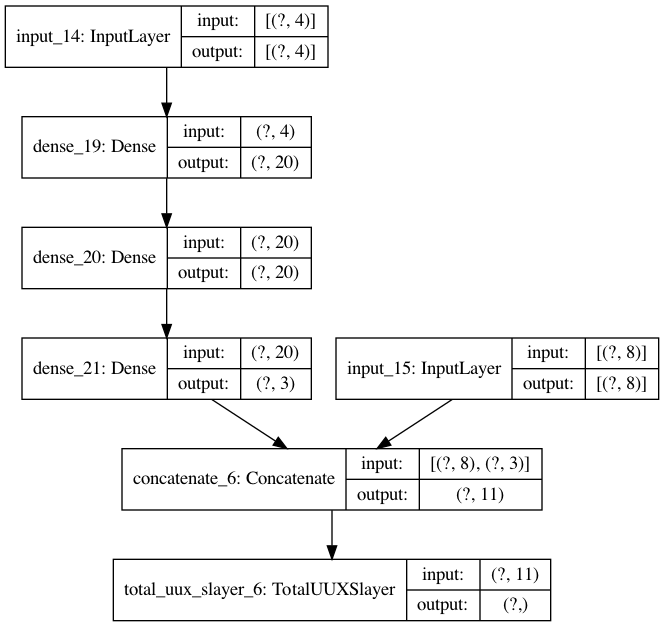

In [51]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [52]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(lr=.000000000005),
    loss = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()],
)

In [47]:
globalModel.summary()

Model: "GlobalModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 20)           100         input_12[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 20)           420         dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 3)            63          dense_17[0][0]                   
________________________________________________________________________________________

In [48]:
X1 = np.random.normal(size=(100, 4))
X2 = np.random.normal(size=(100, 8))
y1 = np.random.normal(size=(100, 3))
y2 = np.random.normal(size=(100,))

In [49]:
globalModel.fit(x=[X1, X2], y=[y1, y2], epochs=1)

4/4 [==============================] - 0s 6ms/step - loss: nan - dense_18_loss: nan - total_uux_slayer_5_loss: nan


In [44]:
globalModel.weights

[<tf.Variable 'dense_13/kernel:0' shape=(4, 20) dtype=float32, numpy=
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]], dtype=float32)>,
 <tf.Variable 'dense_13/bias:0' shape=(20,) dtype=float32, numpy=
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], dtype=float32)>,
 <tf.Variable 'dense_14/kernel:0' shape=(20, 20) dtype=float32, numpy=
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, na

In [29]:
globalModel.predict([X1, X2])

[array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],


## General global variable definitions

In [19]:
bhdvcs = BHDVCS()
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

numSets = 15
numReplicas = 30

## Define and compile model

This makes use of the tensorflow [functional api](https://www.tensorflow.org/guide/keras/functional)

In [10]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = uts.TotalUUXSlayer()(totalUUXSInputs) # incorporate cross-sectional function

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

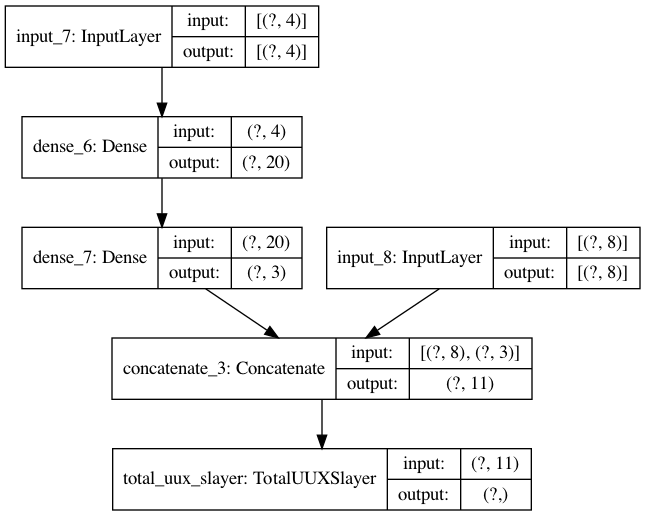

In [22]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [29]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(.02),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [14]:
Wsave = globalModel.get_weights()

## Produce CFFdists

In [49]:
def produceCFFs(numReplicas, data, Wsave):
    '''
    :param numSamples: number of replicas to produce
    :param data: whole DvcsData
    :param Wsave: saved weights
    
    :returns: numpy array of shape (numSets, numReplicas, 3)
    '''

    by_sample = []

    for i in tqdm(range(max(data.df['#Set'])+1)):

        globalModel.set_weights(Wsave) # reset weights to original value

        setI = data.getSet(i) #DvcsData object containing specific set

        by_set = []

        for sample in range(numReplicas):
            
            #this callback enables us to roll the network back to its minimum loss during training
            chkpt_path = 'networks/best-' + str(sample) + '.hdf5'
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=chkpt_path,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)


            globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # the sample Y will generate Fs
                        epochs=2500, verbose=0,
                        callbacks=[model_checkpoint_callback])

            globalModel.load_weights(chkpt_path) # load back minimum loss epoch

            cffs = uts.cffs_from_globalModel(globalModel, setI.Kinematics) # get cffs from middle model

            by_set.append(cffs)

        by_sample.append(by_set)
        
    return np.array(by_sample)

This took about 2 hours to run

In [38]:
results = produceCFFs(30, data, Wsave)

# ReH

In [42]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  17.582291982537622
RMSE:  2.62230203097768
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -0.07816059768698325


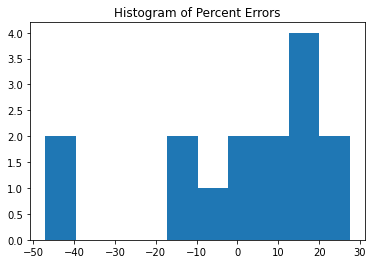

In [43]:
uts.evaluate(y_yhat)

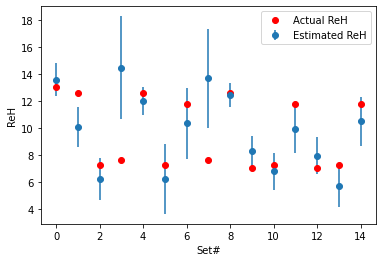

In [44]:
uts.plotError(y_yhat, err, "ReH")

# ReE

In [50]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)

Mean percent error:  17.90242207338664
RMSE:  13.365320875688067
RMSE w yhat=mean:  2.525480507907797
R-squared:  -27.007267395838852


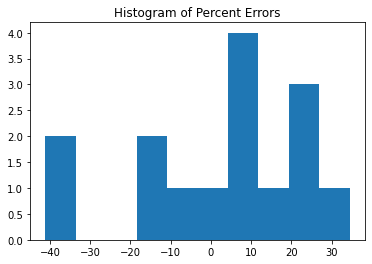

In [51]:
uts.evaluate(y_yhat)

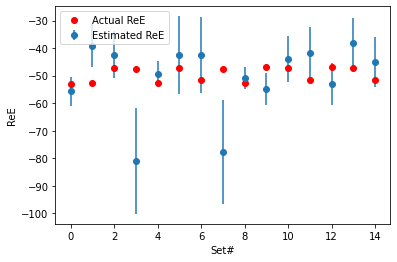

In [53]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  13.752452678886966
RMSE:  1.3588621505320975
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.06197575189024063


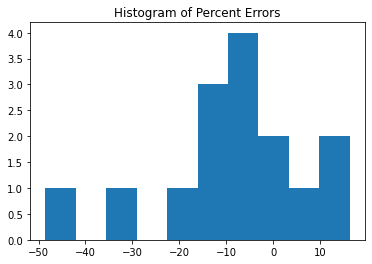

In [45]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

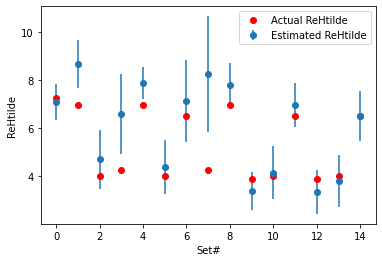

In [46]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Mean percent error:  5.704536590802014
RMSE:  0.002553727446558777
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.9740593416573334


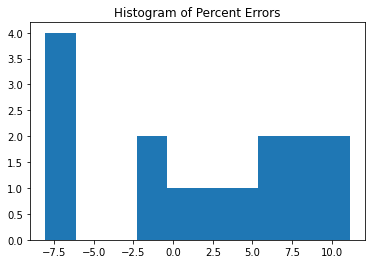

In [47]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

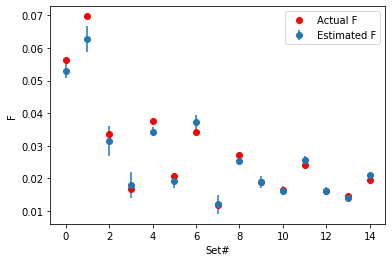

In [48]:
uts.plotError(y_yhat, err, "F")